In [1]:
from collections import Counter
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import numpy as np
import os
import pandas as pd
import re
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.probability import FreqDist
nltk.download ('stopwords')
nltk.download ('punkt')

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

[nltk_data] Downloading package stopwords to /home/titian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/titian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Data Import & Cleaning

Load files, remove unneccessary information and prepare for analysis.

In [2]:
# directory specifications & plot settings
subtitle_dir = "subtitles"
seasons = ["S01", "S02", "S03", "S04"]
colors = ['#CA3A3C', '#F47B3D', '#61A783', '#41A2AE']

# store imported file content
columns = ('season', 'episode', 'title', 'subtitles')
df = pd.DataFrame(columns=columns)


def clean_subtitles(subtitles):
    """
    Cleans list of strings imported from .srt file.
    
    Removes:
    - numbering
    - timestamps
    - empty strings
    - contractions
    - specicial characters
    - upper case leters
    
    Returns: List of remaining strings.
    """
    # remove numbering, empty strings & timestamps
    subtitles = [l for l in subtitles if (not l.isdigit() and l != '' and '-->' not in l)]
    
    # replace contractions
    subtitles = [l.replace("'m", " am")
                  .replace("can't", "cannot") 
                  .replace("n't", " not")
                  .replace("'ve", " have")
                  .replace("'re", " are")
                  .replace("'ll", " will")
                  .replace("'d", " would")
                  .replace("'s", "") # could be "is" or posessive
                 for l in subtitles]
    
    # convert everything to lowercase
    subtitles = [l.lower() for l in subtitles]

    return subtitles

# apply cleaning function to df
df['subtitles'] = df['subtitles'].apply(clean_subtitles)

# order df by season and episode
df = df.sort_values(by=['season', 'episode'])
df = df.reset_index(drop=True)


# loop through all season folders
for s in seasons:
    directory = os.getcwd() + "/subtitles" + "/" + s
    
    # loop through files if directory exists
    try:
        for f in os.listdir(directory):
            if f.endswith(".srt"):
                file_path = os.path.join(directory, f)
                file = open(file_path, mode='r', encoding='utf-8-sig')
                file_content = file.read().splitlines()
                

                subtitles = clean_subtitles(file_content)
                
                df = df.append({'season': int(s[-2:]), 
                                'episode': int(f[4:6]),
                                'title': f[7:-4],
                                'subtitles': ' '.join(subtitles)}, ignore_index=True)

    # directory does not exist
    except FileNotFoundError:
        print("Directory " + subtitle_dir + "/" + s + " not found.")

# order df by season and episode
df = df.sort_values(by=['season', 'episode'])
df = df.reset_index(drop=True)

Get additional metadata for episodes from IMDB

https://www.omdbapi.com/

## Text Exploration & Analytics


- Episodes With Highest Word Count
- Episode Word Count Distribution
- Word count vs. episode length?
- Most frequently used words per episode/season

- Word cloud with longest words?

- Lexical div./dens. vs. rating (maybe vs. episode length?)


### Open Ideas:
- TF-IDF??!! (allows to keep stop words)
- Stemming?!

Identify undesirable words that should be removed.

In [3]:
# tokenize subtitles into words
df['word_tokens'] = df['subtitles'].apply(word_tokenize)

# remove special characters
p = re.compile('[^a-zA-Z\d\s:]')
df['word_tokens_clean'] = df['word_tokens'].apply(lambda x: ["".join(l for l in w if not p.match(w)) for w in x])
df['word_tokens_clean'] = df['word_tokens_clean'].apply(lambda x: [w for w in x if w])

## remove stop words
## also apply to sentence tokens
## 
stop_words = set(stopwords.words("english"))
df['word_tokens_clean'] = df['word_tokens_clean'].apply(lambda x: [w for w in x if w not in stop_words])

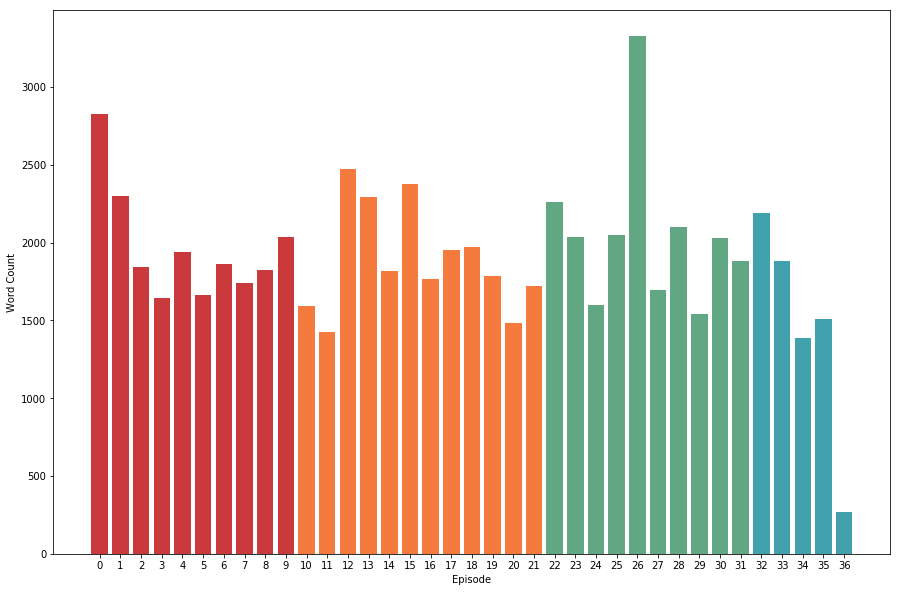

In [4]:
# number of words per episode
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

episodes = df.index
seasons = df['season']
word_counts = df['word_tokens_clean'].str.len()
color_array = [
    colors[0] if s == 1 
    else colors[1] if s == 2 
    else colors[2] if s == 3
    else colors[3] if s == 4
    else '' for s in seasons]

ax.bar(episodes, word_counts, color=color_array)
ax.set_xlabel('Episode')
ax.set_xticks(episodes)
ax.set_xticklabels(episodes)
ax.set_ylabel('Word Count')

plt.show()

## add episode length as line for comparison
##
##


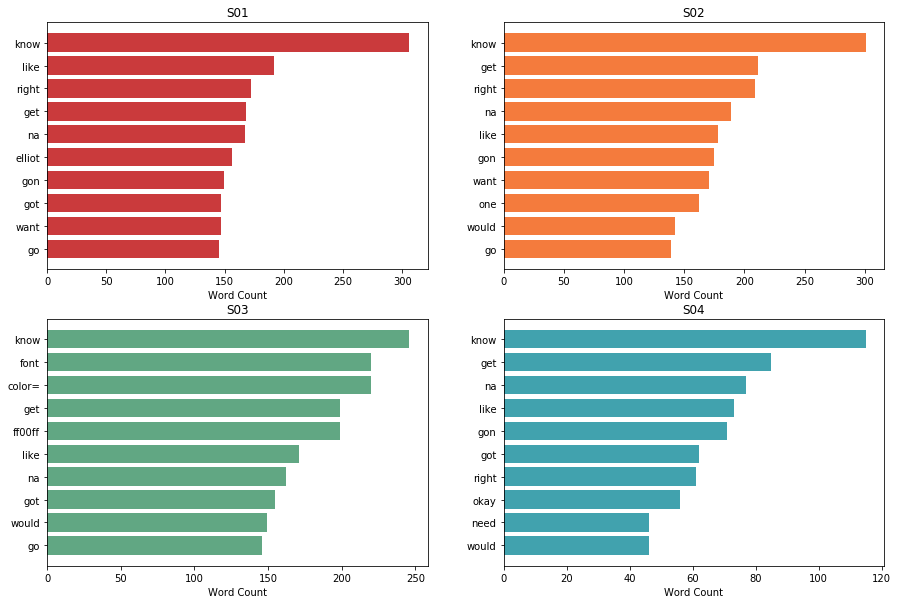

In [5]:
# plot frequency distributions for cleaned word lists for each season
fig, axs = plt.subplots(2, 2, figsize=(15,10))
axs = [ax for sublist in axs for ax in sublist]

# aggregate cleaned words for all seasons
season_word_tokens_clean = df.groupby('season')['word_tokens_clean'].sum()

for i, row in enumerate(season_word_tokens_clean):
    counts = Counter(row).most_common(10)

    axs[i].barh([x[0] for x in counts], [x[1] for x in counts], color=colors[i])
    axs[i].set_title('S0' + str((i + 1)))
    axs[i].set_xlabel('Word Count')
    axs[i].invert_yaxis()

plt.show()

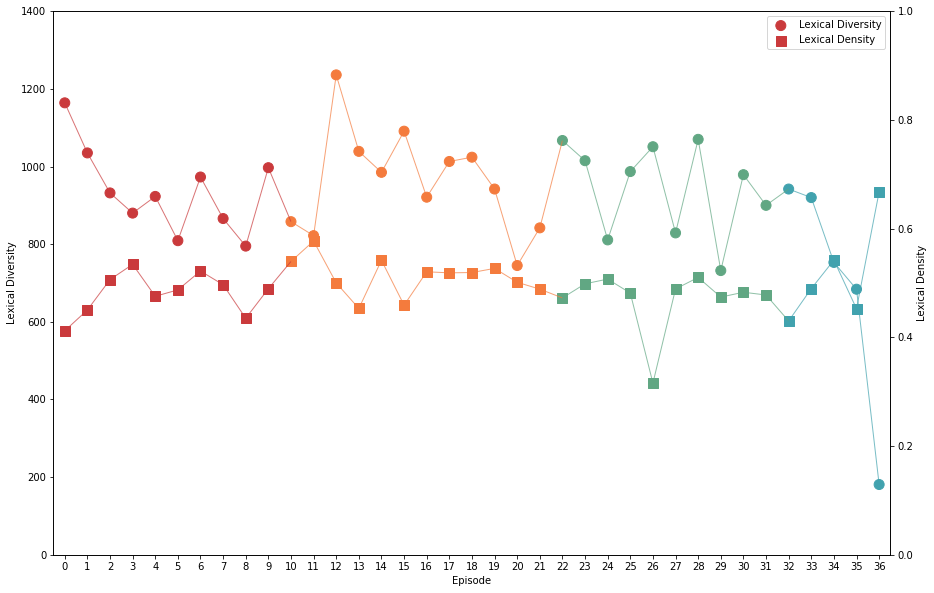

In [6]:
# number of unique words used per episode
def lexical_diversity(words):
    return len(set(words))
df['lexical_diversity'] = df['word_tokens_clean'].apply(lexical_diversity)

# diversity in relation to number of used words
def lexical_density(words):
    return(lexical_diversity(words) / len(words))
df['lexical_density'] = df['word_tokens_clean'].apply(lexical_density)

# plot lexical analysis
def create_segments(x, y):
    """Split line into segments between two points."""
    points = np.array([x, y]).T.reshape(-1, 1, 2)
    segments = np.concatenate([points[:-1], points[1:]], axis=1)
    
    return segments

fig, ax1 = plt.subplots(1, 1, figsize=(15,10))

episodes = list(df.index)
seasons = df['season']
color_array = [
    colors[0] if s == 1 
    else colors[1] if s == 2 
    else colors[2] if s == 3
    else colors[3] if s == 4
    else '' for s in seasons]

# draw line between lexical diversity values
ldiv_segments = create_segments(episodes, df['lexical_diversity'])
lc = LineCollection(ldiv_segments, color=color_array, alpha=0.7)
lc.set_linewidth(1)
ldiv_line = ax1.add_collection(lc)

# plot lexical diversity values
ldiv_scatter = ax1.scatter(episodes, df['lexical_diversity'], marker='o', s=100, 
                         c=color_array, label='Lexical Diversity')

ax1.set_xlim([-0.5, len(episodes) - 0.5])
ax1.set_ylim([0, 1400])
ax1.set_xlabel('Episode')
ax1.set_xticks(episodes)
ax1.set_xticklabels(episodes)
ax1.set_ylabel('Lexical Diversity')

# draw line between lexical density values
ax2 = ax1.twinx()

ldens_segments = create_segments(episodes, df['lexical_density'])
lc = LineCollection(ldens_segments, color=color_array, alpha=0.7)
lc.set_linewidth(1)
ldens_line = ax2.add_collection(lc)


# plot lexical density values
ldens_scatter = ax2.scatter(episodes, df['lexical_density'], marker='s', s=100,
                           c=color_array, label='Lexical Density')

ax2.set_ylim([0, 1])
ax2.set_ylabel('Lexical Density')

# display legend
scatters = [ldiv_scatter, ldens_scatter]
labels = [s.get_label() for s in scatters]
ax2.legend(scatters, labels)

## how to adjust marker color in legend?
##
##
##

plt.show()

## VADER Sentiment Analysis

VADER works best on short texts (a couple sentences at most), and applying it to an entire chapter at once resulted in extreme and largely worthless scores. Instead, I looped over each sentence individually, got the VADER scores, and then took an average of all sentences in a chapter.

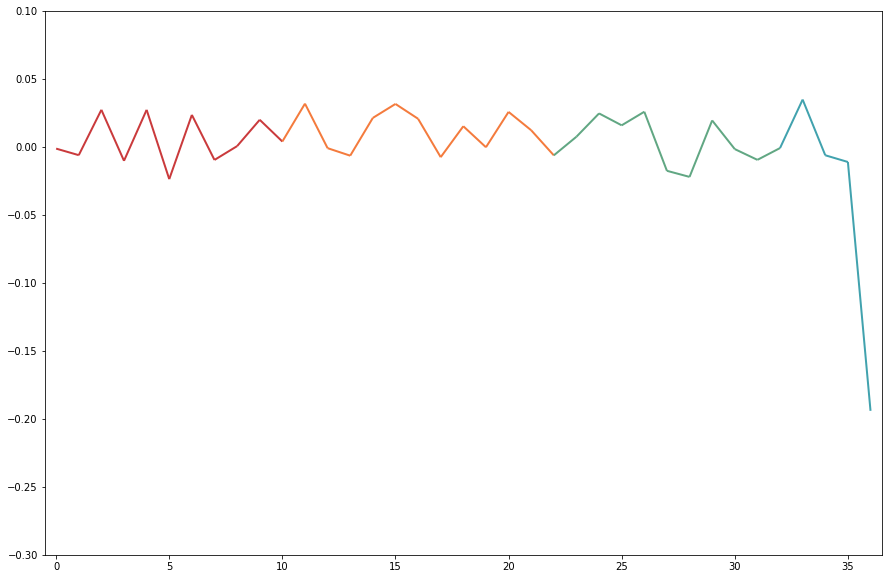

In [14]:
# tokenize subtitles into sentences
df['sentence_tokens'] = df['subtitles'].apply(sent_tokenize)

# calculate sentence Vader scores for all episodes
def analyzeSentences(sentences):
    """Calculate and return VADER compound values for list of strings."""
    analyzer = SentimentIntensityAnalyzer()
    
    compound_scores = []
    for sentence in sentences:
        vs = analyzer.polarity_scores(sentence)
        compound_scores.append(vs['compound'])
        
    return compound_scores

df['sentence_scores'] = df['sentence_tokens'].apply(analyzeSentences)
df['mean_scores'] = df['sentence_scores'].apply(lambda x: sum(x) / len(x))

# plot VADER mean scores for all episodes
fig, ax = plt.subplots(1, 1, figsize=(15,10))

episodes = list(df.index)
seasons = df['season']
color_array = [
    colors[0] if s == 1 
    else colors[1] if s == 2 
    else colors[2] if s == 3
    else colors[3] if s == 4
    else '' for s in seasons]

mean_compound_score_segments = create_segments(episodes, df['mean_scores'])
lc = LineCollection(mean_compound_score_segments, color=color_array)
lc.set_linewidth(2)
mean_compound_score_line = ax.add_collection(lc)

ax.set_xlim([-0.5, len(episodes) - 0.5])
ax.set_ylim([-0.3, 0.1])

plt.show()

In [8]:
df.head()

,season,episode,title,subtitles,word_tokens,word_tokens_clean,lexical_diversity,lexical_density,sentence_tokens,sentence_scores,mean_scores
0,1,1,eps1.0_hellofriend.mov,"hello, friend. ""hello, friend."" that lame. may...","[hello, ,, friend, ., ``, hello, ,, friend, .,...","[hello, friend, hello, friend, lame, maybe, gi...",1164,0.412035,"[hello, friend., ""hello, friend."", that lame.,...","[0.4939, 0.0, -0.4215, 0.0, 0.0, 0.0, -0.5574,...",-0.001112
1,1,2,eps1.1_ones-and-zer0es.mpeg,"what i am about to tell you is top secret, evi...","[what, i, am, about, to, tell, you, is, top, s...","[tell, top, secret, evil, corp., tyrell, welli...",1035,0.450392,"[what i am about to tell you is top secret, ev...","[-0.5574, 0.0772, -0.296, 0.0, -0.5574, 0.0, 0...",-0.005934
2,1,3,eps1.2_d3bug.mkv,i will be the youngest executive this company ...,"[i, will, be, the, youngest, executive, this, ...","[youngest, executive, company, ever, seen, rig...",932,0.506247,[i will be the youngest executive this company...,"[0.0, -0.296, 0.0, 0.3612, 0.0, 0.0, 0.0, 0.0,...",0.027435
3,1,4,eps1.3_da3m0ns.mp4,steel mountain. the hacker dilemma. what to do...,"[steel, mountain, ., the, hacker, dilemma, ., ...","[steel, mountain, hacker, dilemma, bunch, data...",880,0.534305,"[steel mountain., the hacker dilemma., what to...","[0.0, -0.1779, -0.4939, -0.6597, 0.0, 0.0, 0.0...",-0.010078
4,1,5,eps1.4_3xpl0its.wmv,he wants to hack steel mountain climate contro...,"[he, wants, to, hack, steel, mountain, climate...","[wants, hack, steel, mountain, climate, contro...",923,0.475528,[he wants to hack steel mountain climate contr...,"[-0.5423, 0.0, 0.0, -0.5256, 0.0, 0.0, -0.4019...",0.027406
